# clasificador_XGboost con SMOTE (solo 3 clases)

In [ ]:
#!pip install imblearn

In [1]:
#!/usr/bin/env python
# coding: utf-8

# Librerías base
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# SMOTE para oversampling
from imblearn.over_sampling import SMOTE

In [9]:
# Cargar archivo
file_path = "Encuesta Digital Girls_SP&ENG_D_3clases_250405.xlsx"
df_new = pd.read_excel(file_path)
df_new.drop(['ID'], axis=1, inplace=True)

In [11]:
# por categorias profesionales
df_new['Label'].value_counts()

BUSINESS AND FINANCE    212
OTHERS                  160
STEM                    108
Name: Label, dtype: int64

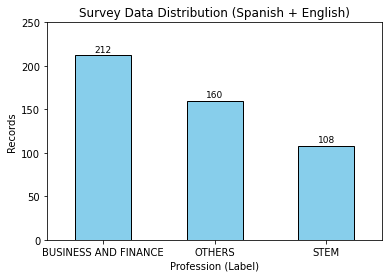

In [17]:
import matplotlib.pyplot as plt
# Crear gráfico de barras
ax = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Títulos y etiquetas
plt.title("Survey Data Distribution (Spanish + English)")
plt.xlabel("Profession (Label)")
plt.ylabel("Records")
plt.xticks(rotation=0, ha='center')

plt.ylim(0, 250)

# Añadir etiquetas de valor encima de cada barra
for i, value in enumerate(label_counts):
    ax.text(i, value + 2, str(value), ha='center', va='bottom', fontsize=9)

#plt.tight_layout()
plt.show()

In [ ]:
# Procesamiento
df_model = df_new.copy()
le = LabelEncoder()
df_model['Label'] = le.fit_transform(df_model['Label'])

# Codificación one-hot
df_model = pd.get_dummies(df_model, columns=['Asignatura1', 'Asignatura1.1', 'Personalidad'])

# Variables predictoras y objetivo
X = df_model.drop(columns=['Label'])
y = df_model['Label']

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Limpieza de nombres de columnas
X_train.columns = [col.replace('[', '').replace(']', '').replace('<', '_').replace('>', '_') for col in X_train.columns]
X_test.columns = X_train.columns

In [3]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [4]:
# Entrenar modelo
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train_bal, y_train_bal)

C:\Users\jeca\anaconda3\envs\nlp_portilla\lib\site-packages\xgboost\core.py:158: UserWarning: [11:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [5]:
# Predicciones
y_pred = model.predict(X_test)

# Métricas
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
labels = le.inverse_transform(sorted(y_test.unique()))

Accuracy: 0.5208333333333334


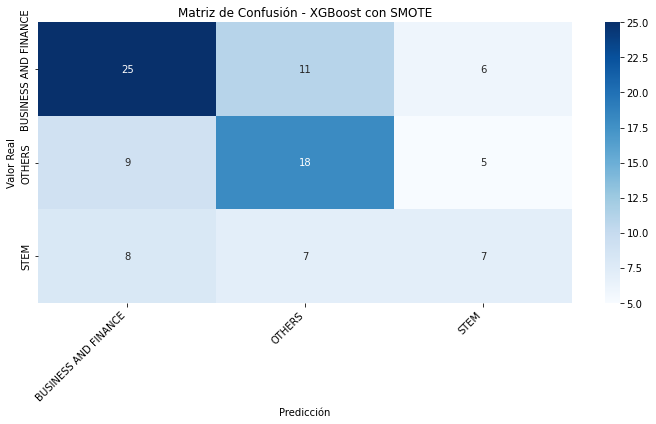

In [6]:
print("Accuracy:", accuracy)

# Matriz de confusión
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - XGBoost con SMOTE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Reporte detallado por clase
report = classification_report(
    y_test,
    y_pred,
    target_names=le.inverse_transform(sorted(y_test.unique())),
    digits=2
)

print("\nReporte de métricas por clase:\n")
print(report)


Reporte de métricas por clase:

                      precision    recall  f1-score   support

BUSINESS AND FINANCE       0.60      0.60      0.60        42
              OTHERS       0.50      0.56      0.53        32
                STEM       0.39      0.32      0.35        22

            accuracy                           0.52        96
           macro avg       0.49      0.49      0.49        96
        weighted avg       0.52      0.52      0.52        96



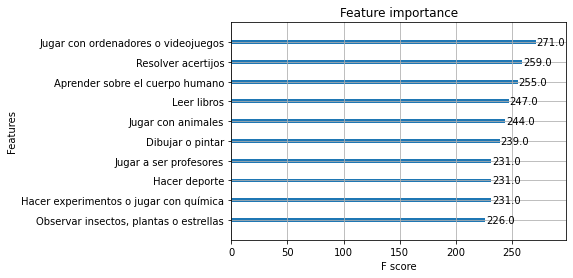

In [8]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.show()